# genereative model 

In [1]:
from brian2 import *
%matplotlib inline
from brian2 import SpikeGeneratorGroup
from brian2 import NeuronGroup
import numpy as np
import random
import pandas as pd

faire un modele generatif où on aurait : 
- une première couche de i neurones = nb de PGs 
- une deuxième couche où on aurait j neurones, connectés à tous les i qui génèrent des PGs en réponse à un spike émit par un i 

on aurait donc {i, j} avec par ex i emet un spike à 10ms et connecte les neurones j1, j3 et j4 qui émettent des spikes à 10ms, 15ms et 6ms respectivement 

-> on définit donc par ti le timing d'occurence d'un PG et par tj le pattern du PG

### variable definition

In [2]:
Ni = 5 #nb de PGs différents
Nj = 10 #nb de N
n_pattern = 10 # nb d'occurrence des PGs 
duration = 100000*msecond

PGs_pattern = {}
PGs_id_tps = {}

a = np.arange(Ni)
cmap = plt.cm.get_cmap("plasma")
color_dict = pd.Series({i:cmap(i/len(a)) for i,k in enumerate(a)})

In [3]:
# --- def du moment d'occurence des PGs -------------------------------------------------------------------------------------------------

i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 


# --- def des projections des neurones pré-syn (i.e. des des PGs) -----------------------------------------------------------------------

i_syn=[]
n_syn = []

for k in range(Ni) : 
    n_j = np.random.randint(3, Nj, size = 1) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 

n_syn = sum(n_syn) 


# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

weight = np.random.rand(n_syn)
delay = np.random.rand(n_syn)*0.1*second

### NN simulation for PGs generation 

In [4]:
for i in range(n_pattern) :
    c = SpikeGeneratorGroup(Ni, [i_indices[i]], [i_temps[i]/ms*msecond])
    c_spike= SpikeMonitor(c)
    
    d = NeuronGroup(Nj, 
                    ''' dv/dt = -v/tau : volt
                        tau : second''',
                    threshold= 'v > 0.01*volt',
                    reset= 'v = -0.07*volt',
                    method = 'exact')
    
    d.tau = 0.01*second
    d_spike = SpikeMonitor(d)

    s = Synapses(c,d, on_pre='v+=0.1*w*volt', model = 'w:1')
    
    for k in range(Ni):
        s.connect(i = k , j = i_syn[k])
               
    s.w[:,:] = weight
    s.delay[:,:] = delay
    
    run(duration)
    
    PGs_id_tps[i] = (c_spike.t, c_spike.i)
    PGs_pattern[i] = (d_spike.t, d_spike.i) # je vourdrais avoir l'echelle de temps en ms et non en s 
    

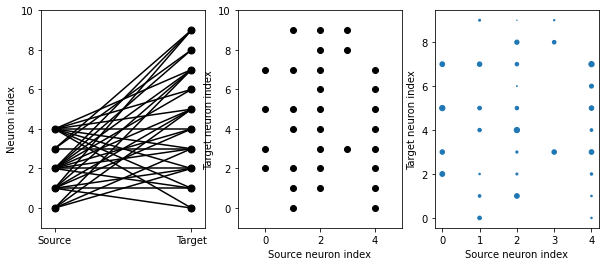

In [5]:
def visualise_connectivity(syn): # ajouter les delays
    Ns = len(syn.source)
    Nt = len(syn.target)
    figure(figsize=(10, 4))
    subplot(131)
    plot(zeros(Ns), arange(Ns), 'ok', ms=7)
    plot(ones(Nt), arange(Nt), 'ok', ms=7)
    for i, j in zip(syn.i, syn.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(132)
    plot(syn.i, syn.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    subplot(133) 
    scatter(syn.i, syn.j, syn.w*30 )
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(s)

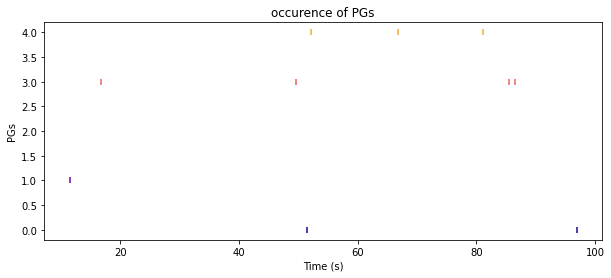

In [6]:
plt.figure(figsize=(10,4))
for i in range(n_pattern) :
    plt.scatter(PGs_id_tps[i][0], PGs_id_tps[i][1], color = color_dict[i_indices[i]], marker = "|")
    xlabel('Time (s)')
    ylabel('PGs')
    title('occurence of PGs')

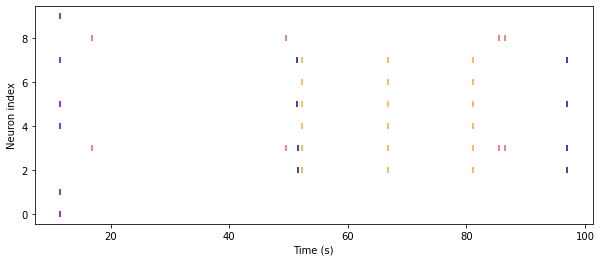

In [7]:
all_PGs_pattern = []
plt.figure(figsize=(10,4))
for i in range(n_pattern) :
    plt.scatter(PGs_pattern[i][0], PGs_pattern[i][1], color = color_dict[i_indices[i]], marker = "|")
    xlabel('Time (s)')
    ylabel('Neuron index');

# unsupervised recognition of PGs

## detection of temporal patterns 

In [8]:
# obtenir le temps de chaque spike, dans l'ordre d'apparition, indépendemment du PGs auquel il appartient
all_spike_time = []

for k in range(n_pattern) :
    for i in range(len(PGs_pattern[k][1])):
        all_spike_time.append(tuple((round(PGs_pattern[k][0][i]*1000/second), PGs_pattern[k][1][i]))) #
        
all_spike_time.sort(key=lambda y: y[0])

In [9]:
all_spike_time

[(11433, 1),
 (11433, 5),
 (11442, 0),
 (11456, 7),
 (11518, 9),
 (11520, 4),
 (16812, 8),
 (16834, 3),
 (49598, 8),
 (49620, 3),
 (51484, 7),
 (51503, 5),
 (51540, 2),
 (51571, 3),
 (52189, 6),
 (52214, 2),
 (52231, 3),
 (52237, 4),
 (52253, 7),
 (52262, 5),
 (66767, 6),
 (66792, 2),
 (66809, 3),
 (66815, 4),
 (66831, 7),
 (66840, 5),
 (81047, 6),
 (81073, 2),
 (81089, 3),
 (81096, 4),
 (81112, 7),
 (81121, 5),
 (85532, 8),
 (85555, 3),
 (86552, 8),
 (86574, 3),
 (96922, 7),
 (96941, 5),
 (96978, 2),
 (97009, 3)]

In [14]:
temps_tot

100000.0

In [15]:
# def de ma fenetre temporelle pour reconnaître les PGs
temps_tot = int(duration/msecond)
t_window = 200 #ms
nb_wind = int(temps_tot/t_window)
X = np.zeros((nb_wind, Nj, t_window))

In [17]:
for k in range(nb_wind) :
    for t,i in (all_spike_time) : 
        if t<t_window : 
            X[1][i][t] = 1
            print('ok')
        if t_window*(k-1)<t<t_window*k : 
            X[k][i][t-t_window*(k-1)] = 1 
            print('okk')

okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk
okk


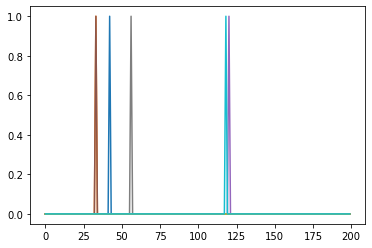

In [35]:
plot(X[58].T)

In [ ]:
all_spike_time

## cam's k-means